<a href="https://colab.research.google.com/github/Engefu-Brilliant/machine_learning/blob/main/malariadataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

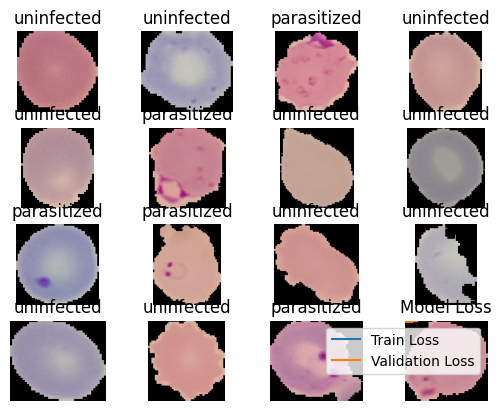

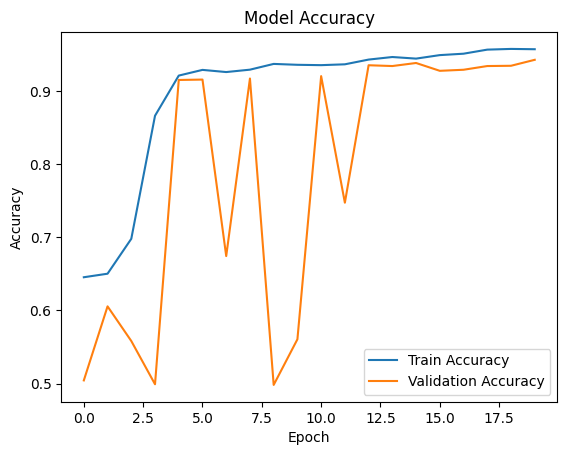

1/1 [==============================] - 0s 18ms/step


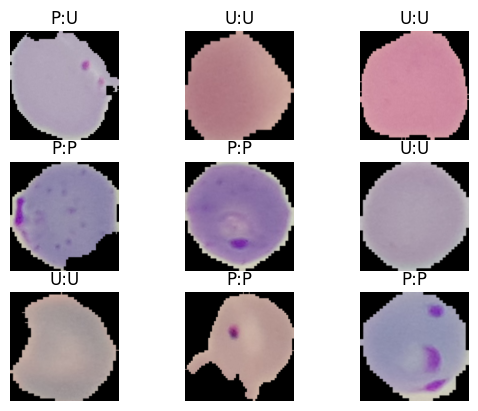

In [5]:
from re import VERBOSE
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Load dataset
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

# Function to split dataset
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

# Ratios for train, validation, and test sets
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

# Split dataset
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Print example data
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

# Visualize example data
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

# Image size for resizing
IM_SIZE = 224

# Function to resize and rescale images
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0, label

# Apply preprocessing to datasets
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

# Print example preprocessed data
for image, label in train_dataset.take(1):
    print(image, label)

# Batch size for training
BATCH_SIZE = 32

# Shuffle and batch datasets
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Define the model architecture
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation="relu"),
    BatchNormalization(),

    Dense(10, activation="relu"),
    BatchNormalization(),

    Dense(1, activation="sigmoid"),
])

# Print model summary
model.summary()

# Define example labels and predictions for Binary Crossentropy loss
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 0]

# Compute Binary Crossentropy loss
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# MODEL EVALUATION AND TESTING
test_dataset = test_dataset.batch(1)
test_dataset
model.evaluate(test_dataset)

# Define the function to determine parasite or not
def parasite_or_not(x):
    if x < 0.5:
        return 'P'
    else:
        return 'U'

# MODEL PREDICTIONS
parasite_or_not(model.predict(test_dataset.take(1))[0][0])


# Function to determine parasite or not
def parasite_or_not(x):
    if x < 0.5:
        return 'P'
    else:
        return 'U'

# Predictions and visualization
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    plt.title(f'{parasite_or_not(label.numpy()[0])}:{parasite_or_not(model.predict(image)[0][0])}')
    plt.axis('off')
plt.show()
